# 2. MNIST Without ResNet

In [2]:
#import boilerplate
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.all import *

In [3]:
#MNIST dataset
path = untar_data(URLs.MNIST)

In [64]:
#list folder structure
path.ls()

(#2) [Path('C:/Users/heybl/.fastai/data/mnist_png/testing'),Path('C:/Users/heybl/.fastai/data/mnist_png/training')]

In [4]:
#setup training dir
train_path = path/'training'
#setup testing dir
test_path = path/'testing'


In [5]:
#parent folder label scheme
fname = (train_path/'0').ls()[0]
fname.parent.name

'0'

In [6]:
#build training data set

#get training images from training directory
train_images = get_image_files(train_path)
#open images into a list of tensors n * 28 * 28
train_item_list = [tensor(Image.open(img)).cuda() for img in train_images]
#use parent folder name to create a list of labels
train_labels_list = [int(img.parent.name) for img in train_images]
#stack into a n x 784 tensor, convert to floats, normalize be dividing by 255
train_items = (torch.stack(train_item_list).float()/255).view(-1, 28 * 28)
#label list to 1 dim tensor
train_labels = tensor(train_labels_list).cuda().view(-1,1)
train_items.shape, train_labels.shape


(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [7]:
#zip into a training "dataset"
train_data = list(zip(train_items, train_labels))

In [11]:
#build testing data set

#get training images from training directory
test_images = get_image_files(test_path)
#open images into a list of tensors n * 28 * 28
test_item_list = [tensor(Image.open(img)).cuda() for img in test_images]
#use parent folder name to create a list of labels
test_labels_list = [int(img.parent.name) for img in test_images]
#stack into a n x 784 tensor, convert to floats, normalize be dividing by 255
test_items = (torch.stack(test_item_list).float()/255).view(-1, 28 * 28)
#label list to 1 dim tensor
test_labels = tensor(test_labels_list).cuda().view(-1,1)
test_items.shape, test_labels.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

In [12]:
#zip into a testing "dataset"
test_data = list(zip(test_items, test_labels))

In [13]:
#use dataloader
train_dl = DataLoader(train_data, batch_size=256)
test_dl = DataLoader(test_data, batch_size=256)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


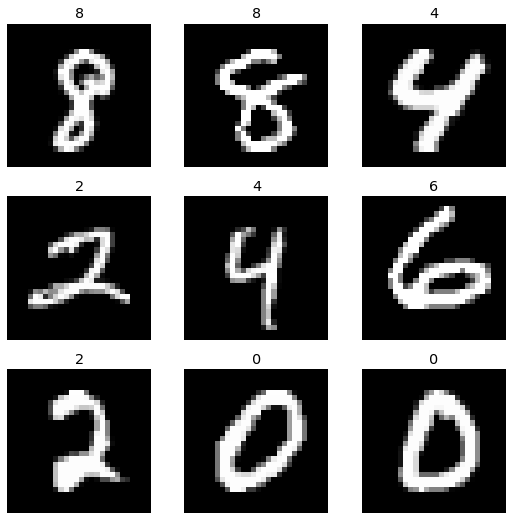

In [14]:
#wanted to try using the DataBlock, as well - oh, this is cool
nums_db = DataBlock(blocks = (ImageBlock, CategoryBlock), get_items=get_image_files, splitter=RandomSplitter(seed=42), get_y=parent_label)
dls = nums_db.dataloaders(path/'training')
dls.show_batch()

In [15]:
#define loss function -use the CrossEntropyLoss function to calculate the loss from the predictions and actual values
def mnist_loss(pred, actual):
    loss = nn.CrossEntropyLoss()
    return loss(pred, actual.squeeze())
    


In [16]:
#calculate the gradient, by first calculating the predictions from the model, calculating the loss
def calc_grad(xb,yb,model):
    #get predictions from model
    pred = model(xb)
    #calculat loss from predictions and actual values
    loss = mnist_loss(pred, yb)
    #calculate the gradient
    loss.backward()
    return loss

In [17]:
#calculate batch accuracy
def batch_accuracy(pred, actual):
    #this took a sec to work out, get the maximum predicted category value, the index of that is the predicted digit
    digit_pred = pred.max(dim=1)[1]
    return (digit_pred == actual.squeeze()).float().mean()

In [18]:
# driver for one training epoch
def train_epoch(model, optimizer):
    batch_loss = []
    #iterate through image/label pairs in data set
    for xb, yb in train_dl:
        #get the prediction from the model, calc the loss, get the gradient
        batch_loss.append(calc_grad(xb, yb, model))
        #update the weights
        optimizer.step()
        #zero the gradients
        optimizer.zero_grad()
    return tensor(batch_loss).mean() 

In [19]:
class BasicOptim:
    #link class to model parameters and learning rate
    def __init__(self, params, lr): 
        self.params, self.lr = list(params), lr
    
    #update weights based on gradient and learning rate
    def step(self):
        for p in self.params:
            p.data -= p.grad.data * self.lr

    #reset gradient        
    def zero_grad(self):
        for p in self.params:
            p.grad = None

In [20]:
#basic network with 4 linear layers interspersed with 3 non-linearities
#accept a 28 * 28 size image and output 10 categories
simple_net = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
).cuda()


In [21]:
#thats some poop starting accuracy (0.1114) close to random chance
batch_accuracy(simple_net(test_items), test_labels)

tensor(0.1114, device='cuda:0')

In [132]:
opt = BasicOptim(simple_net.parameters(), lr=0.1)

In [134]:
def train_model(model, epochs, opt):
    for i in range(epochs):
        avg_batch_loss = train_epoch(model, opt)
        print(i, avg_batch_loss.item(), batch_accuracy(simple_net(test_items), test_labels).item())

In [142]:
%%time
train_model(simple_net, 100, opt)

0 7.386626384686679e-05 0.9738999605178833
1 7.320328586502001e-05 0.9738999605178833
2 7.263103179866448e-05 0.9738999605178833
3 7.195913349278271e-05 0.9738999605178833
4 7.141413516364992e-05 0.9738999605178833
5 7.077083137119189e-05 0.9738999605178833
6 7.019354961812496e-05 0.9738999605178833
7 6.960259634070098e-05 0.9738999605178833
8 6.901309825479984e-05 0.9738999605178833
9 6.847656186437234e-05 0.9738999605178833
10 6.787434540456161e-05 0.9738999605178833
11 6.72946116537787e-05 0.9738999605178833
12 6.675018084933981e-05 0.9738999605178833
13 6.619741907343268e-05 0.9738999605178833
14 6.566127558471635e-05 0.973800003528595
15 6.511038372991607e-05 0.973800003528595
16 6.461504381150007e-05 0.973800003528595
17 6.404705345630646e-05 0.973800003528595
18 6.354360084515065e-05 0.973800003528595
19 6.304714042926207e-05 0.973800003528595
20 6.249182479223236e-05 0.973800003528595
21 6.204166129464284e-05 0.973800003528595
22 6.151999696157873e-05 0.973800003528595
23 6.101

In [143]:
#save my trained model
torch.save(simple_net.state_dict(), "mnist_full_weights.pth")

In [22]:
#load the saved model
simple_net.load_state_dict(torch.load("mnist_full_weights.pth"))

<All keys matched successfully>

In [23]:
#test final accuracy
batch_accuracy(simple_net(test_items), test_labels)

tensor(0.9735, device='cuda:0')